In [5]:
library(ggplot2, quietly = TRUE)
library(reshape2, quietly = TRUE)
library(plotly, quietly = TRUE)

In [3]:
options(stringsAsFactors = F)

matchToIDTable <- function(ids,tbl, column, returnColumn="unique.cellid") {
  sapply(ids, function(x) {
    myx <- grep(paste0("((///)|^)",Hmisc::escapeRegex(x),"((///)|$)"), tbl[,column])
    if(length(myx) > 1){
      stop("Something went wrong in curating ids, we have multiple matches")
    }
    if(length(myx) == 0){return(NA_character_)}
    return(tbl[myx, returnColumn])
  })
}

## Determine replicates across datasets (gCSI, CCLE, GDSC)

In [7]:
##read in current cell annotations
cell_all <- read.csv(file = "rnaseq_meta/cell_annotation_all.csv", na.strings=c("", " ", "NA"))

In [8]:
#read in gcsi cell annotations
gcsi <- read.csv(file = "rnaseq_meta/gcsi_rnaseq_meta.csv")
gcsi$cellid <- matchToIDTable(ids=gcsi$Cell_line , tbl = cell_all, column = "GNE.cellid", returnColumn = "unique.cellid")
rownames(gcsi) <- gcsi$alias

#read in ccle cell annotations
ccle <- read.csv(file = "rnaseq_meta/ccle_rnaseq_meta.csv")
ccle$cellid <- matchToIDTable(ids=ccle$Cell_Line , tbl = cell_all, column = "CCLE.cellid", returnColumn = "unique.cellid")
rownames(ccle) <- ccle$Run

#read in gdsc cell annotations
gdsc <- read.csv(file = "rnaseq_meta/gdsc_rnaseq_meta.txt", sep = "\t")
gdsc <- gdsc[which(!gdsc$Comment.SUBMITTED_FILE_NAME. == "15552_5.cram"),]
gdsc$cellid <- matchToIDTable(ids=gdsc$Source.Name, tbl = cell_all, column = "GDSC_rnaseq.cellid", returnColumn = "unique.cellid")
gdsc$files <- gsub(".cram","",gdsc$Comment.SUBMITTED_FILE_NAME.)
rownames(gdsc) <- gdsc$files

In [10]:
#filter metadata -> keep intersected cell lines only
intersected_rnacells <- Reduce(intersect, list(gdsc$cellid, ccle$cellid, gcsi$cellid))

gcsi <- gcsi[which(gcsi$cellid %in% intersected_rnacells),]
ccle <- ccle[which(ccle$cellid %in% intersected_rnacells),]
gdsc <- gdsc[which(gdsc$cellid %in% intersected_rnacells),]

print(intersected_rnacells) #replicates

 [1] "A-427"      "C2BBe1"     "CL-40"      "COLO 741"   "DU145"     
 [6] "HCC1187"    "HCC1806"    "HCT 116"    "HCT 15"     "HeLa"      
[11] "HT115"      "HT-29"      "HT-55"      "Karpas-620" "KNS-62"    
[16] "Ku812"      "LS180"      "MDA-MB-361" "MDST8"      "NCI-H510A" 
[21] "SNU-1"      "SNU-16"     "OVKATE"     "RKO"        "SET-2"     
[26] "SiHa"       "Rh30"       "SK-N-SH"    "SNU-C1"     "SR"        
[31] "SU-DHL-10"  "SU-DHL-5"   "SU-DHL-6"   "SUIT-2"     "SW1116"    
[36] "SW1463"     "SW1573"     "SW403"      "SW48"       "SW620"     
[41] "SW780"      "SW837"      "SW948"      "U266B1"     "UACC-812"  
[46] "WSU-DLCL2"  "YAPC"       "ZR-75-30"  


## Summarize circRNA counts (CIRI2)

In [12]:
#function reads in CIRI2 output, and summarizes # of junction reads for each sample (>= 2 junction reads kept only)
summarizeCIRI <- function(dir_path){
  
  ciri_files <- list.files(path=dir_path,  pattern = "\\.tsv$", full.names = T)
  circ_counts_df <- data.frame(matrix(ncol=2, nrow = length(ciri_files)))
  colnames(circ_counts_df) <- c("sample", "count")
  for (f in 1:length(ciri_files)) {
    sample <- read.table(file = ciri_files[f], 
                         sep = '\t', 
                         skip = 1,
                         header = FALSE)
    
    colnames(sample) <- c("circRNA_ID","chr","circRNA_start","circRNA_end","junction_reads", "SM_MS_SMS", "non_junction_reads", "junction_reads_ratio", "circRNA_type", "gene_id", "strand","junction_reads_ID")
    sample_name <- gsub("\\..*","", ciri_files[f])
    sample_name <- gsub(".*/","", sample_name)    
    sample <- sample[which(sample$circRNA_type=="exon"),]
    sample <- sample[which(sample$junction_reads >= 2),]
    count <- sum(sample$junction_reads)
    circ_counts_df[f,] <- c(sample_name,count)
  }
  return(circ_counts_df)
} 

In [69]:
gcsi_ciri_counts <- summarizeCIRI(dir_path = "results/CIRI2/gCSI/result")
ccle_ciri_counts <- summarizeCIRI(dir_path = "results/CIRI2/CCLE/result")
gdsc_ciri_counts <- summarizeCIRI(dir_path = "results/CIRI2/GDSC/result")
hansen_ciri_counts <- summarizeCIRI(dir_path = "results/CIRI2/hansen/result") #both Ribo-zero + RNAse-R
hansen_ciri_matched <- summarizeCIRI(dir_path = "results/CIRI2/hansen_match/result") #poly-A equivalent to Hansen data
gdsc_ribozero_ciri_counts <- summarizeCIRI(dir_path = "results/CIRI2/GDSC_Ribo/result") #GDSC Ribo-Zero samples (HCT-116, HeLa)

In [70]:
#clean up sample names (remove 'gcsi' & 'gdsc' strings from samples)
gcsi_ciri_counts$sample <- gsub("gcsi", "", gcsi_ciri_counts$sample)
gdsc_ciri_counts$sample <- gsub("gdsc", "", gdsc_ciri_counts$sample)

rownames(gcsi_ciri_counts) <- gcsi_ciri_counts$sample
rownames(ccle_ciri_counts) <- ccle_ciri_counts$sample
rownames(gdsc_ciri_counts) <- gdsc_ciri_counts$sample

gdsc_ribozero_ciri_counts$sample <- c("HCT 116","HeLa")
rownames(gdsc_ribozero_ciri_counts) <- gdsc_ribozero_ciri_counts$sample

#average SR technical replicate circRNA count in gCSI
gcsi_ciri_counts$cellid <- gcsi$cellid[match(rownames(gcsi_ciri_counts), rownames(gcsi))]
gcsi_SR_mean <- mean(as.numeric(gcsi_ciri_counts$count[which(gcsi_ciri_counts$cellid=="SR")]))
gcsi_ciri_counts[which(gcsi_ciri_counts$cellid=="SR"),][2,"count"] <- gcsi_SR_mean
gcsi_ciri_counts <- gcsi_ciri_counts[-which(gcsi_ciri_counts$sample=="587641"),]

#get unique.cellids for samples + order CCLE & GDSC, GDSC-Ribo unique.cellid by gCSI unique.cellid
ccle_ciri_counts$cellid <- ccle$cellid[match(rownames(ccle_ciri_counts), rownames(ccle))]
ccle_ciri_counts <- ccle_ciri_counts[match(gcsi_ciri_counts$cellid, ccle_ciri_counts$cellid),]

gdsc_ciri_counts$cellid <- gdsc$cellid[match(rownames(gdsc_ciri_counts), rownames(gdsc))]
gdsc_ciri_counts <- gdsc_ciri_counts[match(gcsi_ciri_counts$cellid, gdsc_ciri_counts$cellid),]

gdsc_ribozero_ciri_counts <- gdsc_ribozero_ciri_counts[match(gcsi_ciri_counts$cellid,rownames(gdsc_ribozero_ciri_counts)),]

In [91]:
#create combined dataframe of CIRI2 counts for each replicate across gCSI, CCLE, GDSC
ciri_combined <- data.frame("gcsi"=as.numeric(gcsi_ciri_counts$count), 
                            "ccle"=as.numeric(ccle_ciri_counts$count), 
                            "gdsc"=as.numeric(gdsc_ciri_counts$count),
                            "gdsc-ribo"=as.numeric(gdsc_ribozero_ciri_counts$count))

rownames(ciri_combined) <- gcsi_ciri_counts$cellid
colnames(ciri_combined) <- c("gCSI","CCLE","GDSC","GDSC-Ribo")

head(ciri_combined)

,gCSI,CCLE,GDSC,GDSC-Ribo
,<dbl>,<dbl>,<dbl>,<dbl>
SNU-1,200,694,3881,NA
SNU-16,385,355,2615,NA
HCC1187,512,969,1064,NA
HCC1806,898,706,425,NA
UACC-812,57,700,2352,NA
ZR-75-30,53,524,181,NA


In [24]:
hansen_ciri_counts

sample,count
<chr>,<chr>
22Rv1neg,4797
22Rv1pos,106052
LNCaPneg,10579
LNCaPpos,108949
PC3neg,10413
PC3pos,125466


In [25]:
hansen_ciri_matched

sample,count
<chr>,<chr>
22Rv1ccle,677
LNCaPccle,362
PC3ccle,417
PC3gcsi,458


## Summarize circRNA counts (CIRCexplorer2)

In [26]:
#function reads in CIRCexplorer2 output, and summarizes # of junction reads for each sample (>= 2 junction reads kept only)
summarizeCIRCexplorer <- function(dir_path){
  
  circ_files <- list.files(path=dir_path,  pattern = ".txt", full.names = TRUE, recursive = TRUE)
  circ_counts_df <- data.frame(matrix(ncol=2, nrow = length(circ_files)))
  colnames(circ_counts_df) <- c("sample", "count")
  for (f in 1:length(circ_files)) {
    sample <- read.table(file = circ_files[f], 
                         sep = '\t',
                         header = FALSE)
    
    colnames(sample) <- c("chrom","start","end", "name","score","strand","thickStart","thickEnd","itemRgb","exonCount","exonSizes", "exonOffsets", "readNumber", "circType", "geneName", "isoformName", "index", "flankIntron")

    sample_name <- sub(".*/ *(.*?) *.txt.*", "\\1", circ_files[f])
    sample <- sample[which(sample$circType=="circRNA"),]
    sample <- sample[which(sample$readNumber >= 2),]
    count <- sum(sample$readNumber)
    circ_counts_df[f,] <- c(sample_name,count)
  }
  return(circ_counts_df)
} 

In [86]:
gcsi_circ_counts <- summarizeCIRCexplorer(dir_path = "results/CIRCexplorer2/gCSI/unmapped_method/annotate")
ccle_circ_counts <- summarizeCIRCexplorer(dir_path = "results/CIRCexplorer2/CCLE/unmapped_method/annotate")
gdsc_circ_counts <- summarizeCIRCexplorer(dir_path = "results/CIRCexplorer2/GDSC/unmapped_method/annotate")
hansen_circ_counts <- summarizeCIRCexplorer(dir_path = "results/CIRCexplorer2/hansen/annotate") #both Ribo-zero + RNAse-R
hansen_circ_matched <- summarizeCIRCexplorer(dir_path = "results/CIRCexplorer2/hansen_match/annotate") #poly-A equivalent to Hansen data
gdsc_ribozero_circ_counts <- summarizeCIRCexplorer(dir_path = "results/CIRCexplorer2/GDSC_Ribo/annotate") #GDSC Ribo-Zero samples (HCT-116, HeLa)


In [87]:
#clean up sample names (remove 'gcsi' & 'gdsc' strings from samples)
gcsi_circ_counts$sample <- sub(".*gcsi *(.*?) *_.*", "\\1", gcsi_circ_counts$sample)
rownames(gcsi_circ_counts) <- gcsi_circ_counts$sample

ccle_circ_counts$sample <- sub("* *(.*?) *_circular.*", "\\1", ccle_circ_counts$sample)
rownames(ccle_circ_counts) <- ccle_circ_counts$sample

gdsc_circ_counts$sample <- sub(".*gdsc *(.*?) *_circular.*", "\\1", gdsc_circ_counts$sample)
rownames(gdsc_circ_counts) <- gdsc_circ_counts$sample

gdsc_ribozero_circ_counts$sample <- c("HCT 116","HeLa")
rownames(gdsc_ribozero_circ_counts) <- gdsc_ribozero_circ_counts$sample

#average SR technical replicate circRNA count in gCSI
gcsi_circ_counts$cellid <- gcsi$cellid[match(rownames(gcsi_circ_counts), rownames(gcsi))]
gcsi_SR_mean <- mean(as.numeric(gcsi_circ_counts$count[which(gcsi_circ_counts$cellid=="SR")]))
gcsi_circ_counts[which(gcsi_circ_counts$cellid=="SR"),][2,"count"] <- gcsi_SR_mean
gcsi_circ_counts <- gcsi_circ_counts[-which(gcsi_circ_counts$sample=="587641"),]

#get unique.cellids for samples + order CCLE & GDSC & GDSC-ribo unique.cellid by gCSI unique.cellid
ccle_circ_counts$cellid <- ccle$cellid[match(rownames(ccle_circ_counts), rownames(ccle))]
ccle_circ_counts <- ccle_circ_counts[match(gcsi_circ_counts$cellid, ccle_circ_counts$cellid),]

gdsc_circ_counts$cellid <- gdsc$cellid[match(rownames(gdsc_circ_counts), rownames(gdsc))]
gdsc_circ_counts <- gdsc_circ_counts[match(gcsi_circ_counts$cellid, gdsc_circ_counts$cellid),]

gdsc_ribozero_circ_counts <- gdsc_ribozero_circ_counts[match(gcsi_circ_counts$cellid,rownames(gdsc_ribozero_circ_counts)),]

In [92]:
#create combined dataframe of CIRCexplorer counts for each replicate across gCSI, CCLE, GDSC
circ_combined <- data.frame("gcsi"=as.numeric(gcsi_circ_counts$count), 
                            "ccle"=as.numeric(ccle_circ_counts$count), 
                            "gdsc"=as.numeric(gdsc_circ_counts$count),
                            "gdsc-ribo"=as.numeric(gdsc_ribozero_circ_counts$count))
rownames(circ_combined) <- gcsi_circ_counts$cellid
colnames(circ_combined) <- c("gCSI","CCLE","GDSC","GDSC-Ribo")

head(circ_combined)

,gCSI,CCLE,GDSC,GDSC-Ribo
,<dbl>,<dbl>,<dbl>,<dbl>
SNU-1,255,741,3766,NA
SNU-16,341,859,2586,NA
HCC1187,857,1176,1837,NA
HCC1806,525,502,457,NA
UACC-812,15,319,2288,NA
ZR-75-30,30,323,69,NA


In [30]:
hansen_circ_counts

sample,count
<chr>,<chr>
22Rv1neg_circularRNA_known,9034
22Rv1pos_circularRNA_known,128429
LNCaPneg_circularRNA_known,12658
LNCaPpos_circularRNA_known,123892
PC3neg_circularRNA_known,14022
PC3pos_circularRNA_known,142643


In [32]:
hansen_circ_matched

sample,count
<chr>,<chr>
22Rv1ccle_circularRNA_known,2260
LNCaPccle_circularRNA_known,1968
PC3ccle_circularRNA_known,1843
PC3gcsi_circularRNA_known,2262


## Validate circRNA's with matched RNAse-R Hansen samples (CIRI2, CIRCexplorer)

In [34]:
##filter circRNA's (CIRI2) which have at least 1.5-fold enrichment in matching RNAse-R sample (polyA vs RNAse-R / Ribo-zero vs RNAse-R)
filterCIRI <- function(nonRNAseR_dir, RNAseR_dir, suff){
  #"*neg.tsv$" <- for ribominus
  #"\\.tsv$"<- for poly-A selected data
  ciri_files <- list.files(path=nonRNAseR_dir, pattern = suff, full.names = T)
  circ_counts_df <- data.frame(matrix(ncol=2, nrow = length(ciri_files)))
  colnames(circ_counts_df) <- c("sample", "count")
  for (f in 1:length(ciri_files)) {
    sample <- read.table(file = ciri_files[f], 
                         sep = '\t', 
                         skip = 1,
                         header = FALSE)
    
    sample_name <- gsub("\\..*","", ciri_files[f])
    sample_name <- gsub(".*/","", sample_name)
    match_name <- gsub("ccle|gcsi", "",ciri_files[f])
    match_name <- gsub("\\..*","", match_name)
    match_name <- gsub(".*/","", match_name)
    match_name <- gsub("neg","", match_name)
    
    hansen_match <- read.table(file = paste0(RNAseR_dir, match_name,"pos.tsv"), 
                               sep = '\t', 
                               skip = 1,
                               header = FALSE)
    
    colnames(sample) <- c("circRNA_ID","chr","circRNA_start","circRNA_end","junction_reads", "SM_MS_SMS", "non_junction_reads", "junction_reads_ratio", "circRNA_type", "gene_id", "strand","junction_reads_ID")
    colnames(hansen_match) <- c("circRNA_ID","chr","circRNA_start","circRNA_end","junction_reads", "SM_MS_SMS", "non_junction_reads", "junction_reads_ratio", "circRNA_type", "gene_id", "strand","junction_reads_ID")

    sample_match <- sample[which(sample$circRNA_type=="exon"),]
    sample_match <- sample_match[which(sample_match$junction_reads >= 2),]  
    
    hansen_match <- hansen_match[which(hansen_match$circRNA_type=="exon"),]
    hansen_match <- hansen_match[which(hansen_match$junction_reads >= 2),]
    
    sample_match <- sample_match[which(sample_match$circRNA_ID %in% hansen_match$circRNA_ID),]
    hansen_match <- hansen_match[which(hansen_match$circRNA_ID %in% sample_match$circRNA_ID),]
    hansen_match  <- hansen_match[order(sample_match$circRNA_ID),]
    
    filtered <- sample_match[hansen_match$junction_reads/sample_match$junction_reads >= 1.5,]

    count <- sum(filtered$junction_reads)
    circ_counts_df[f,] <- c(sample_name,count)
  }
  return(circ_counts_df)
} 


In [41]:
#validated circRNA's from 22Rv1 (CCLE), LNCaP(CCLE), PC3(CCLE/gCSI) using matched Hansen RNAse-R enriched samples
validated_polyA_ciri <- filterCIRI(nonRNAseR_dir = "results/CIRI2/hansen_match/result", 
                                RNAseR_dir = "results/CIRI2/hansen/result/",
                                suff = "\\.tsv$")

#validated circRNA's from 22Rv1, LNCaP, and PC3 Hansen Ribo-Zero samples using matched Hansen RNAse-R enriched samples
validated_RiboZero_ciri <- filterCIRI(nonRNAseR_dir = "results/CIRI2/hansen/result", 
                                       RNAseR_dir = "results/CIRI2/hansen/result/",
                                       suff = "*neg.tsv$")

In [42]:
validated_polyA_ciri

sample,count
<chr>,<chr>
22Rv1ccle,10
LNCaPccle,36
PC3ccle,25
PC3gcsi,83


In [43]:
validated_RiboZero_ciri

sample,count
<chr>,<chr>
22Rv1neg,3018
LNCaPneg,5740
PC3neg,5577


In [48]:
##filter circRNA's (CIRCexplorer2) which have at least 1.5-fold enrichment in matching RNAse-R sample (polyA vs RNAse-R / Ribo-zero vs RNAse-R)
filterCIRC <- function(nonRNAseR_dir, RNAseR_dir, suff){
  #"*neg*" <- for ribominus
  #"\\.txt$"<- for poly-A selected data
  circ_files <- list.files(path=nonRNAseR_dir,  pattern = suff, full.names = T, recursive = TRUE)
  circ_counts_df <- data.frame(matrix(ncol=2, nrow = length(circ_files)))
  colnames(circ_counts_df) <- c("sample", "count")
  for (f in 1:length(circ_files)) {
    sample <- read.table(file = circ_files[f], 
                         sep = '\t',
                         header = FALSE)
    
    sample_name <- gsub("_circularRNA_known.txt","", circ_files[f])
    sample_name <- gsub(".*/","", sample_name)
    match_name <- gsub("neg", "",sample_name)
    match_name <- gsub("ccle|gcsi", "",match_name)
    
    hansen_match <- read.table(file = paste0(RNAseR_dir, "/" ,match_name, "pos", "/", match_name,"pos", "_circularRNA_known.txt"),
                               sep = '\t',
                               header = FALSE)
    
    colnames(sample) <- c("chrom","start","end", "name","score","strand","thickStart","thickEnd","itemRgb","exonCount","exonSizes", "exonOffsets", "readNumber", "circType", "geneName", "isoformName", "index", "flankIntron")
    colnames(hansen_match) <- c("chrom","start","end", "name","score","strand","thickStart","thickEnd","itemRgb","exonCount","exonSizes", "exonOffsets", "readNumber", "circType", "geneName", "isoformName", "index", "flankIntron")
    
    sample_match <- sample[which(sample$circType=="circRNA"),]
    sample_match <- sample_match[which(sample_match$readNumber >= 2),]  
    
    hansen_match <- hansen_match[which(hansen_match$circType=="circRNA"),]
    #hansen_match <- hansen_match[which(hansen_match$readNumber >= 2),]
    
    sample_match$pos <- paste0(sample_match$chrom,sample_match$start,sample_match$end)
    hansen_match$pos <- paste0(hansen_match$chrom,hansen_match$start,hansen_match$end)
    
    sample_match <- sample_match[which(sample_match$pos %in% hansen_match$pos),]
    hansen_match <- hansen_match[which(hansen_match$pos %in% sample_match$pos),]
    hansen_match  <- hansen_match[match(sample_match$pos, hansen_match$pos),]
    
    filtered <- sample_match[hansen_match$readNumber/sample_match$readNumber >= 1.5,]
    
    count <- sum(filtered$readNumber)
    circ_counts_df[f,] <- c(sample_name,count)
  }
  return(circ_counts_df)
} 

In [93]:
#validated circRNA's from 22Rv1 (CCLE), LNCaP(CCLE), PC3(CCLE/gCSI) using matched Hansen RNAse-R enriched samples
validated_polyA_circ <- filterCIRC(nonRNAseR_dir = "results/CIRCexplorer2/hansen_match/annotate", 
                                       RNAseR_dir = "results/CIRCexplorer2/hansen/annotate",
                                       suff = "\\.txt$")


#validated circRNA's from 22Rv1, LNCaP, and PC3 Hansen Ribo-Zero samples using matched Hansen RNAse-R enriched samples
validated_RiboZero_circ <- filterCIRC(nonRNAseR_dir = "results/CIRCexplorer2/hansen/annotate", 
                                       RNAseR_dir = "results/CIRCexplorer2/hansen/annotate",
                                       suff = "*neg*")

In [94]:
validated_polyA_circ

sample,count
<chr>,<chr>
22Rv1ccle,40
LNCaPccle,54
PC3ccle,92
PC3gcsi,79


In [95]:
validated_RiboZero_circ

sample,count
<chr>,<chr>
22Rv1neg,5338
LNCaPneg,9923
PC3neg,10511


## circRNA read-counts distribution (gCSI, CCLE, GDSC)

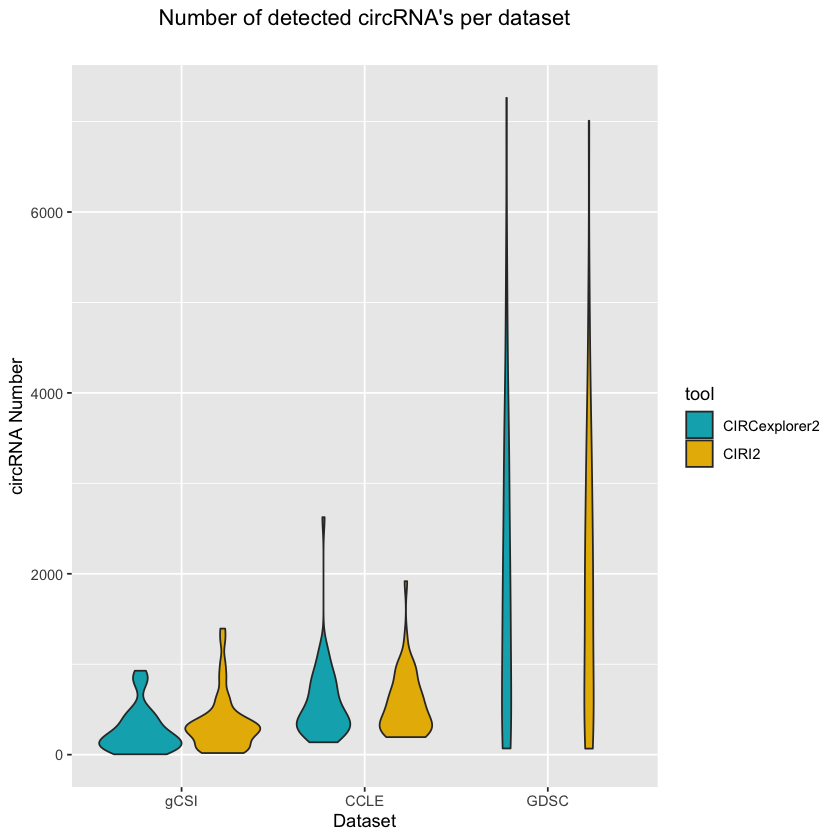

In [109]:
df.m <- reshape2::melt(ciri_combined[,c("gCSI","CCLE","GDSC")], id.vars = NULL)
df.m2 <- reshape2::melt(circ_combined[,c("gCSI","CCLE","GDSC")], id.vars = NULL)
df.m$tool <- "CIRI2"
df.m2$tool <- "CIRCexplorer2"
df.m3 <- rbind(df.m2,df.m)

ggplot(df.m3, aes(x = variable, y = value, fill=tool)) + geom_violin() + 
   scale_fill_manual(values = c("#00AFBB", "#E7B800", "#FC4E07"))  + labs(title="Number of detected circRNA's per dataset", 
                                                                                                                subtitle="",
                                                                                                                x="Dataset",
                                                                                                                y="circRNA Number") + theme(legend.position="right", plot.title = element_text(hjust = 0.5))
          